In [1]:
from pathlib import Path
from tqdm import tqdm

import torch 
import torchvision 
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F

import cv2
import matplotlib.pyplot as plt

## Explain how Faster RCNN works

In [2]:
# Load a pre-trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = fasterrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()

/home/harshamupparaju/Softwares/anaconda3/envs/CS_GY_6613_1/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/harshamupparaju/Softwares/anaconda3/envs/CS_GY_6613_1/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [3]:
## Load the test video
video_path = Path('./data/Football_match_[l3NJNFmg09k].f136.mp4')
cap = cv2.VideoCapture(str(video_path))
out = cv2.VideoWriter('./data/football_match_object_detection_output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (1920, 1080))
output_image_dir = Path('./data/football_match_object_detection_output_images')
output_image_dir.mkdir(exist_ok=True)
final_images = []

pbar = tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Convert the frame to a tensor
    img = F.to_tensor(frame)

    # Add a batch dimension
    img = img.unsqueeze(0).to(device)

    # Make a prediction
    with torch.no_grad():
        prediction = model(img)


    # Draw the boxes on the image
    img = img.squeeze(0)

    labels = [f'id:{l.item()}' for l in prediction[0]['labels']]

    draw = torchvision.utils.draw_bounding_boxes(image=img, boxes=prediction[0]['boxes'], labels=labels)

    # Save image to disk
    img = draw.squeeze(0)
    img_rgb = img.cpu().numpy().transpose(1, 2, 0)
    img_rgb = (img_rgb * 255).astype('uint8')
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR) 
    img_rgb = F.to_pil_image(img_rgb)
    img_rgb.save(output_image_dir / f'{pbar.n}.png')

    draw = draw.cpu().numpy().transpose(1, 2, 0)
    # Convert to uint 8
    draw = (draw * 255).astype('uint8')
    # draw = cv2.cvtColor(draw, cv2.COLOR_RGB2BGR)
    # out.write(draw)

    ## Save the image
    
    
    pbar.update(1)
    break ## This break can be removed to process the whole video

pbar.close()
cap.release()
out.release()
cv2.destroyAllWindows()

  0%|          | 0/1074 [00:00<?, ?it/s]

  0%|          | 1/1074 [00:00<16:14,  1.10it/s]


## Faster-RCNN has 4 main components:
1. Backbone network (e.g. ResNet)
2. Region Proposal Network (RPN)
3. Region of Interest (RoI) Pooling
4. Classifier and Bounding Box Regressor

### Backbone network
The backbone network is a convolutional neural network that extracts features from the input image. The features are then fed into the RPN and the RoI pooling layer.

### Region Proposal Network (RPN)
The RPN is a fully convolutional network that takes the features from the backbone network and outputs a set of region proposals. Each region proposal is a bounding box that is likely to contain an object. The RPN uses anchor boxes to generate region proposals. The anchor boxes are fixed bounding boxes of different sizes and aspect ratios that are placed at each pixel in the feature map. The RPN predicts the probability of each anchor box containing an object and the coordinates of the bounding box.

### Region of Interest (RoI) Pooling
The RoI pooling layer takes the region proposals from the RPN and extracts fixed-size feature maps from the backbone network. The fixed-size feature maps are then fed into the classifier and bounding box regressor.

### Classifier and Bounding Box Regressor
The classifier is a fully connected network that takes the fixed-size feature maps from the RoI pooling layer and predicts the class of the object in the region proposal. The bounding box regressor is also a fully connected network that takes the fixed-size feature maps from the RoI pooling layer and predicts the coordinates of the bounding box.

### Overall Architecture

```
Input Image -> Backbone Network -> RPN -> RoI Pooling -> Classifier and Bounding Box Regressor
```



#### Let's see how Faster RCNN works in practice with an example:
We first need to attach forward hooks to the network to get the intermediate features. We then pass an image through the network and extract the features from the backbone network. We then pass the features through the RPN to get the region proposals. We then pass the region proposals through the RoI pooling layer to get the fixed-size feature maps. Finally, we pass the fixed-size feature maps through the classifier and bounding box regressor to get the final predictions.

In [4]:
## Write forward hooks for each component
backbone_features = []
rpn_proposals = []
rcnn_proposals = []

def backbone_forward_hook(module, input, output):
    backbone_features.append(output)

def rpn_forward_hook(module, input, output):
    rpn_proposals.append(output)

def rcnn_forward_hook(module, input, output):
    rcnn_proposals.append(output)

Once we have the hooks, we can register them to the model

In [5]:
model.backbone.body.layer4.register_forward_hook(backbone_forward_hook)
model.rpn.register_forward_hook(rpn_forward_hook)
model.roi_heads.register_forward_hook(rcnn_forward_hook)

Now we run one image through the model, the intermediate features are now stored in the lists that we defined earlier


In [6]:
output = model(F.to_tensor(frame).unsqueeze(0).to(device))

Let's visualize the outputs of the intermediate layers of the model

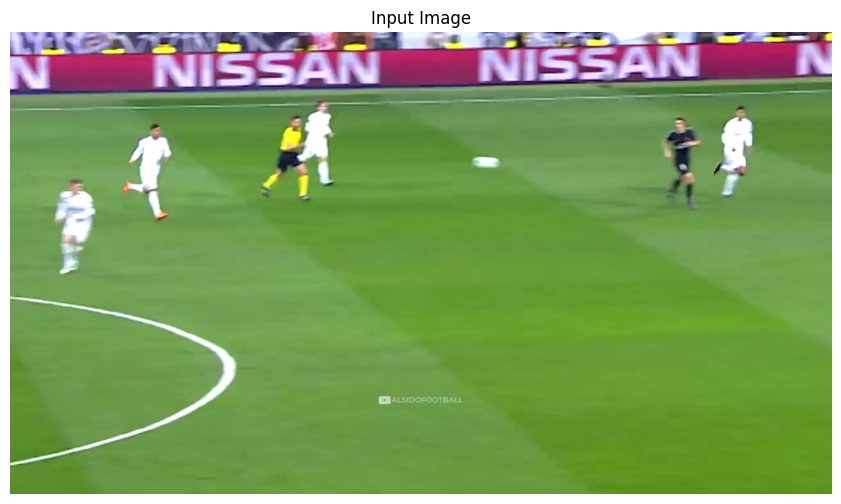

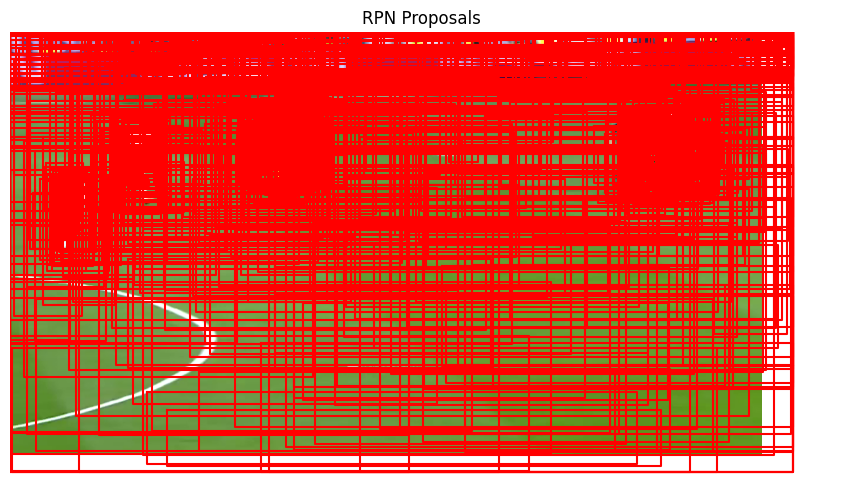

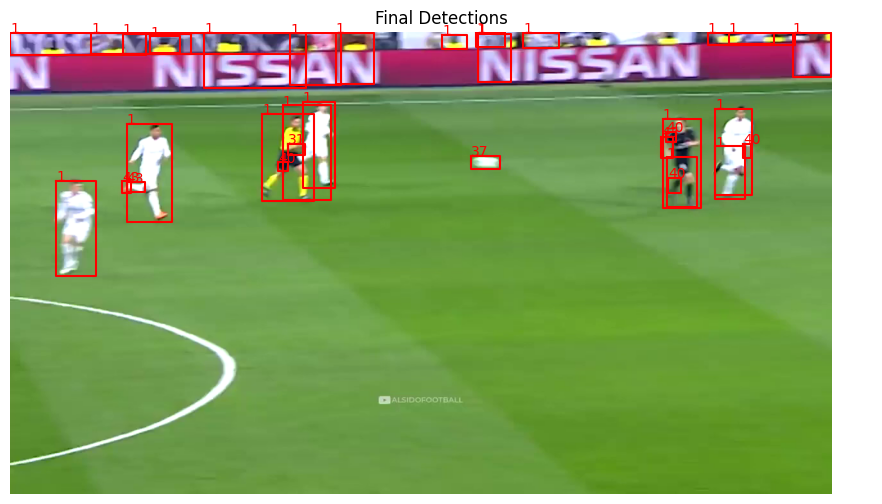

In [7]:
## Plot the image
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 6))
plt.imshow(frame)
plt.title('Input Image')
plt.axis('off')

# ## Visualize the feature map
# plt.figure(figsize=(12, 6))
# plt.imshow(backbone_features[0][0, 0].cpu().detach().numpy(), cmap='gray')
# plt.title('Backbone Feature Map')
# plt.axis('off')

## Visualize the RPN proposals
plt.figure(figsize=(12, 6))
plt.imshow(frame)
rpn_proposals_np = rpn_proposals[0][0][0].cpu().detach().numpy()
for box in rpn_proposals_np:
    x1, y1, x2, y2 = box
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color='r')
plt.title('RPN Proposals')
plt.axis('off')

## Visualize the final detections
plt.figure(figsize=(12, 6))
plt.imshow(frame)
for box, label in zip(rcnn_proposals[0][0][0]['boxes'], rcnn_proposals[0][0][0]['labels']):
    x1, y1, x2, y2 = box.cpu().detach().numpy()
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color='r')
    plt.text(x1, y1, f'{label.item()}', color='r')
plt.title('Final Detections')
plt.axis('off')

plt.show()

In [8]:
# Remove the hooks
model.backbone.body.layer4._forward_hooks.clear()
model.rpn._forward_hooks.clear()
model.roi_heads._forward_hooks.clear()

As we can see here, from the original all the humans are marked with id=1 and the ball is marked with the id=37

# Task 2: Deep-SORT

## Architecture of the tracking solution:

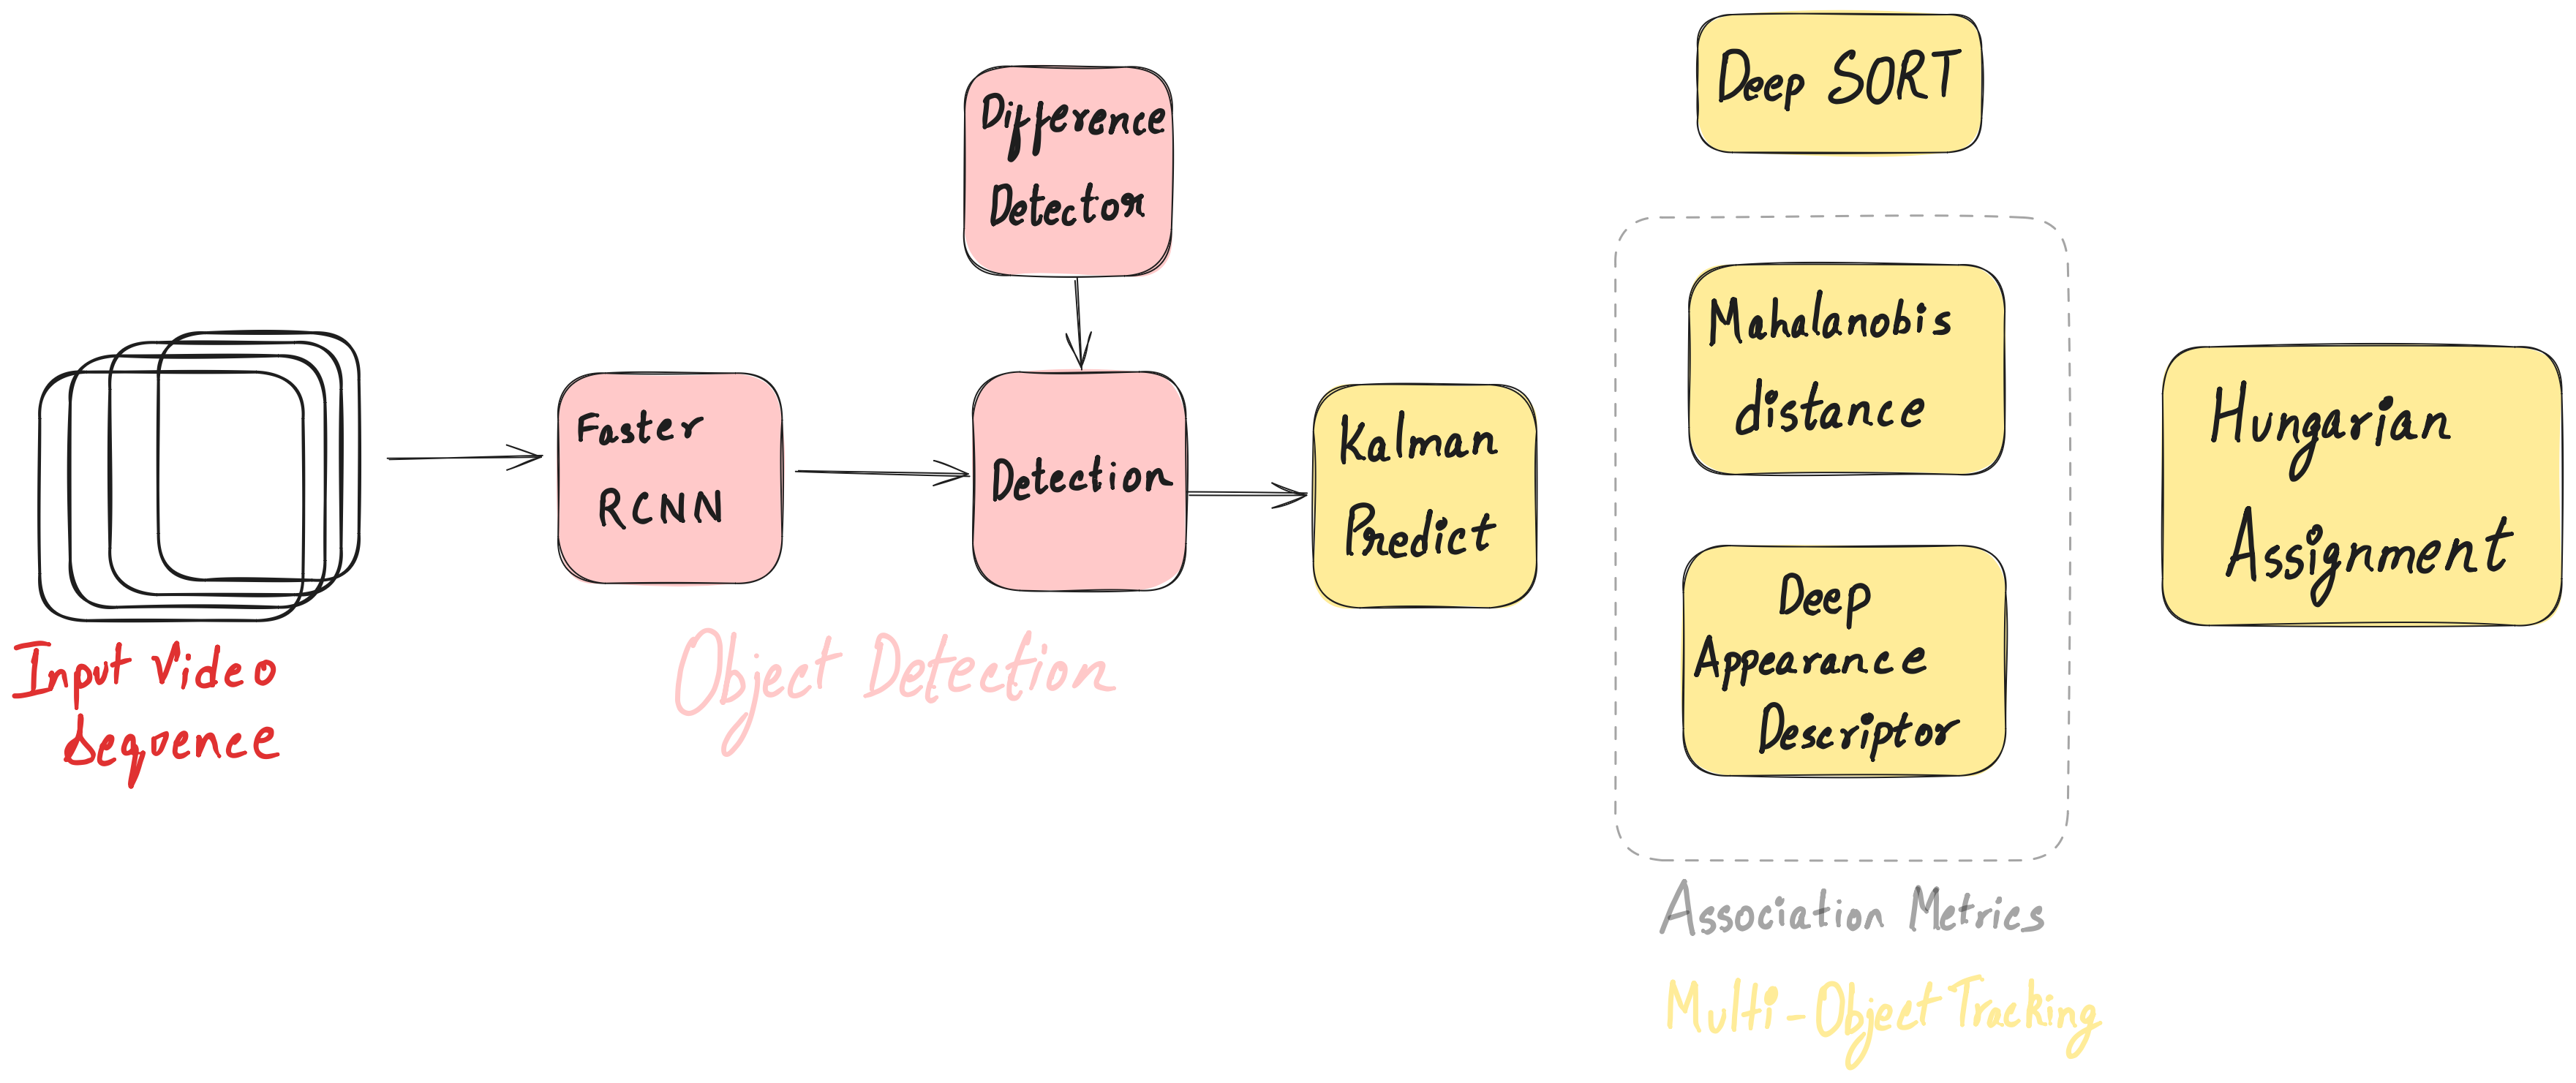

## Key components of the architecture:

### 1. Detection Model (Faster R-CNN): 
Faster R-CNN is a deep learning model designed for object detection, where it identifies and localizes multiple objects within an image. It builds upon previous object detection models like R-CNN and Fast R-CNN, adding a key innovation: the Region Proposal Network (RPN). This enhancement allows it to achieve real-time detection speeds, making it faster and more accurate than earlier models.

The main components of Faster R-CNN are: 
- **Backbone Network**: Typically a pre-trained CNN like VGG16 or ResNet, which extracts features from the input image.
- **Region Proposal Network (RPN)**: A neural network that generates region proposals (bounding boxes) for potential objects in the image. The RPN is a critical improvement introduced in Faster R-CNN, enabling the model to generate region proposals directly within the network. It slides over the feature map, predicting both object boundaries (bounding boxes) and objectness scores, which indicate the likelihood of a region containing an object. This step replaces traditional computationally expensive region proposal methods like selective search.
- **Region of Interest (RoI) Pooling**: After obtaining region proposals from the RPN, RoI pooling extracts fixed-size feature maps from the backbone network's output for each proposal. This step prepares the features for the subsequent classification and bounding box regression tasks.
- **Classification and Bounding Box Regression**: The final layers of the network classify each region proposal into object categories and refine the bounding box coordinates. This step uses the extracted features to predict the presence of objects and their precise locations within the image.

### 2. Kalman Filter for Motion Prediction:
- Deep-SORT uses a Kalman filter to predict the next state (position and velocity) of each tracked object, assuming constant velocity for simplicity. The Kalman filter provides a motion model, allowing the algorithm to predict object locations even if the object is temporarily occluded or partially visible.
- Each track is represented by a state vector that includes position and velocity, and the Kalman filter refines this state vector with each new detection. The similarity between the state vectors can be calculated using Cosine distance.
- Equations:
    - **Kalman Gain**: The Kalman gain determines how much the new measurement should be incorporated into the predicted state. It is calculated based on the covariance of the predicted state and the measurement uncertainty.
    $$ K_k = P_k^` H^T (H P_k^` H^T + R)^{-1} $$
    - **State Update**: The predicted state is updated based on the Kalman gain and the difference between the measurement and the predicted state.
    $$ x_k = x_k^` + K_k (z_k - H x_k^`) $$
    - **Covariance Update**: The covariance matrix is updated to reflect the uncertainty in the predicted state after incorporating the measurement.
    $$ P_k = (I - K_k H) P_k^` $$
- The Kalman filter helps to smooth out noisy detections and maintain the track's state even when detections are intermittent or noisy.

### 3. IoU, Mahalanobis Distance, and Deep Appearance Descriptor:
Deep-SORT uses the Intersection over Union (IoU) and Mahalanobis distance as metrics to evaluate the similarity between predicted positions and detected bounding boxes.
- **Intersection over Union (IoU)**: IoU is a measure of overlap between two bounding boxes. It is calculated as the ratio of the area of intersection to the area of union between the two bounding boxes. IoU is commonly used to assess the accuracy of object detection algorithms by comparing predicted bounding boxes with ground truth annotations.
- **Mahalanobis Distance**: The Mahalanobis distance is a measure of the distance between a point and a distribution, taking into account the covariance of the distribution. In the context of object tracking, the Mahalanobis distance can be used to compare the similarity between predicted positions and detected bounding boxes, considering the uncertainty in the Kalman filter predictions.
- **Deep Appearance Descriptor**: Deep-SORT uses a deep appearance descriptor (CNN feature embeddings) to compare the appearance of objects and associate detections with existing tracks. The similarity between appearance descriptors can be measured using Euclidean or cosine distance.

### 3. Hungarian Algorithm for Data Association (Kuhn-Munkres Algorithm):
- The Hungarian algorithm is an: $$O(n^3) $$ algorithm that solves the assignment problem or maximum/minimum-weighted bipartite matching problem. 
- In the context of object tracking, the Hungarian algorithm is used to associate detections with existing tracks by minimizing the total cost of assignments. The cost matrix is constructed based on the similarity between detections and existing tracks, considering both motion predictions and appearance descriptors.
- The Hungarian algorithm efficiently finds the optimal assignment of detections to tracks, ensuring that each detection is associated with the most likely track based on motion and appearance similarities.

In [9]:
from deep_sort_realtime.deepsort_tracker import DeepSort

# Initialize Deep SORT tracker
tracker = DeepSort(
    max_age=30,
    n_init=3,
    max_cosine_distance=0.3,
    nn_budget=None,
    # use_cuda=torch.cuda.is_available()
)

/home/harshamupparaju/Softwares/anaconda3/envs/CS_GY_6613_1/lib/python3.12/site-packages/deep_sort_realtime/embedder/embedder_pytorch.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

In [10]:
from torchvision.models import resnet50
import torch.nn as nn



# Load a ResNet model for feature extraction
feature_extractor = resnet50(pretrained=True)
feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-1]).to(device)
feature_extractor.eval()

def get_features(crops):
    features = []
    with torch.no_grad():
        for crop in crops:
            crop = F.resize(crop, [224, 224])
            crop = crop.unsqueeze(0).to(device)
            feature = feature_extractor(crop).flatten()
            features.append(feature.cpu().numpy())
    return features

/home/harshamupparaju/Softwares/anaconda3/envs/CS_GY_6613_1/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/harshamupparaju/Softwares/anaconda3/envs/CS_GY_6613_1/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:


def process_frame(frame):
    # Preprocess frame for Faster R-CNN
    # image = F.to_tensor(frame).unsqueeze(0).to(device)
    image = F.to_tensor(frame).unsqueeze(0).to(device)

    
    # Get detections from Faster R-CNN
    with torch.no_grad():
        outputs = model(image)
    
    # Process the detections
    boxes = outputs[0]['boxes'].cpu().numpy()
    scores = outputs[0]['scores'].cpu().numpy()
    labels = outputs[0]['labels'].cpu().numpy()

    # Filter detections with a threshold
    threshold = 0.8
    mask = scores >= threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]

    # Extract features for each box
    crops = [frame[int(y1):int(y2), int(x1):int(x2)] for (x1, y1, x2, y2) in boxes]
    features = get_features([F.to_tensor(crop) for crop in crops])

    # Preprocess the boxes for Deep SORT
    boxes = [[min(x1, x2), min(y1, y2), abs(x2 - x1), abs(y2 - y1)] for x1, y1, x2, y2 in boxes]

    # Format the detections for Deep SORT
    detections = [(box, score, feature) for box, score, feature in zip(boxes, scores, features)]

    # Pass detections to Deep SORT and get tracked objects
    tracks = tracker.update_tracks(detections, frame=frame)
    
    # Visualize results (optional)
    for track in tracks:
        if not track.is_confirmed() or track.time_since_update > 1:
            continue
        track_id = track.track_id
        l, t, w, h = map(int, track.to_ltwh())
        cv2.rectangle(frame, (l, t), (l + w, t + h), (255, 0, 0), 2)
        cv2.putText(frame, f"ID: {track_id}", (l, t - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return frame


In [12]:
cap = cv2.VideoCapture('/media/harshamupparaju/Expansion/Harsha/NYU/Fall_2024/AI/cs_gy_6613_assignments/assignment-3/data/Football_match_[l3NJNFmg09k].f136.mp4')
output_video = cv2.VideoWriter('./data/output_video.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Process each frame with the pipeline
    frame = process_frame(frame)

    # Write the frame to output video
    output_video.write(frame)

    # Display the frame (optional)
    cv2.imshow('Frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
output_video.release()
cv2.destroyAllWindows()
